In [ ]:
# Pour que les changements dans les modules importés (bandits.py) soient pris en compte
%load_ext autoreload
%autoreload 2
# Pour afficher les figures dans le notebook
%matplotlib inline

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Changement des paramètres d'affichage par défaut
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 20, 10
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['font.size'] = 24
mpl.rcParams['lines.markersize'] = 15
# mpl.rcParams.find_all('')

Le fichier `bandits.py` contient les classes pour générer des problèmes de bandits et pour les résoudre. Ce notebook utilise ces objets pour conduire quelques expériences.

Il vous appartient d'étudier le code du notebook **et** du fichier `bandits.py`. Vous complèterez les méthodes manquantes de ce fichier en suivant les indications du notebook. N'hésitez pas à créer d'autres scripts ou cellules de notebook pour tester votre code.

In [ ]:
try:
    # Pour utiliser la correction (prof)
    from bandits_correction import *
    import exp_correction
except:
    # Pour utiliser le code fourni à compléter (étudiants)
    from google.colab import drive
    drive.mount('drive')
    os.chdir('drive/My Drive/univ/master-2/reinforcement-learning')
    from bandits import *

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


# Exemple de problème de bandits
La classe `BernoulliMultiArmedBandits` permet de créer un problème de bandits en donnant les vraies valeurs de chaque bras (valeur entre 0 et 1). Une distribution de Bernoulli est utilisée pour chaque bras, le paramètre de la distribution étant la valeur du bras.

In [ ]:
# Création d'un problème avec 4 bras
bandits_pb = BernoulliMultiArmedBandits(true_values = [0.1, 0.85, 0.7, 0.8])
print(bandits_pb)

4-arms bandit problem with Bernoulli distributions


In [ ]:
print('On tire 10 fois les bras 0 et 1 et on affiche les récompenses:')
n_draws = 10
idx_arms = [0, 1]
for idx_arm in idx_arms:
    results = []
    for i in range(n_draws):
        results.append(int(bandits_pb.step(idx_arm)))
    print(f'arm {idx_arm} : {results}')

On tire 10 fois les bras 0 et 1 et on affiche les récompenses:
arm 0 : [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
arm 1 : [1, 1, 1, 1, 1, 1, 1, 0, 1, 0]


Gain moyen du bras 0 sur 1000 tirages: 0.120 (espérance du bras: 0.100)
Gain moyen du bras 1 sur 1000 tirages: 0.851 (espérance du bras: 0.850)
Gain moyen du bras 2 sur 1000 tirages: 0.701 (espérance du bras: 0.700)
Gain moyen du bras 3 sur 1000 tirages: 0.799 (espérance du bras: 0.800)


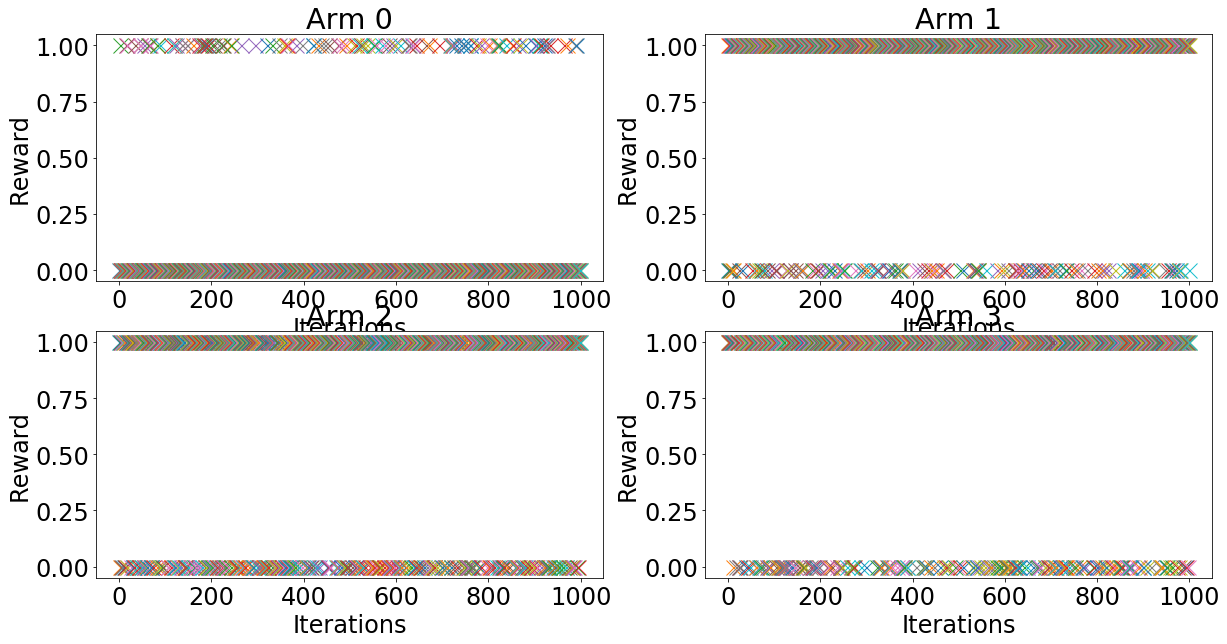

In [ ]:
# Tirer 1000 fois chaque bras 
# et comparer la moyenne des gains aux vraies valeurs des bras (espérances inconnues)
n_draws = 1000
for i_arm in range(bandits_pb.n_arms):
    x = 0
    plt.subplot(2, 2, i_arm+1)
    for i_draw in range(n_draws):
        r = bandits_pb.step(i_arm)
        x += r
        plt.plot(i_draw, r, 'x')
    plt.title('Arm {}'.format(i_arm))
    plt.xlabel('Iterations')
    plt.ylabel('Reward')
    print('Gain moyen du bras {} sur {} tirages: {:.3f} (espérance du bras: {:.3f})'
          .format(i_arm, n_draws, x/n_draws, bandits_pb._true_values[i_arm]))

**À faire.** Étudiez le code de la classe `BernoulliMultiArmedBandits`.

Vraies valeurs des bras: [ 0.76542214 -1.42612891 -0.18848785 -2.18076272 -1.50218095  0.18849019
  0.87211633  0.60074923 -0.76883642 -0.18975449]


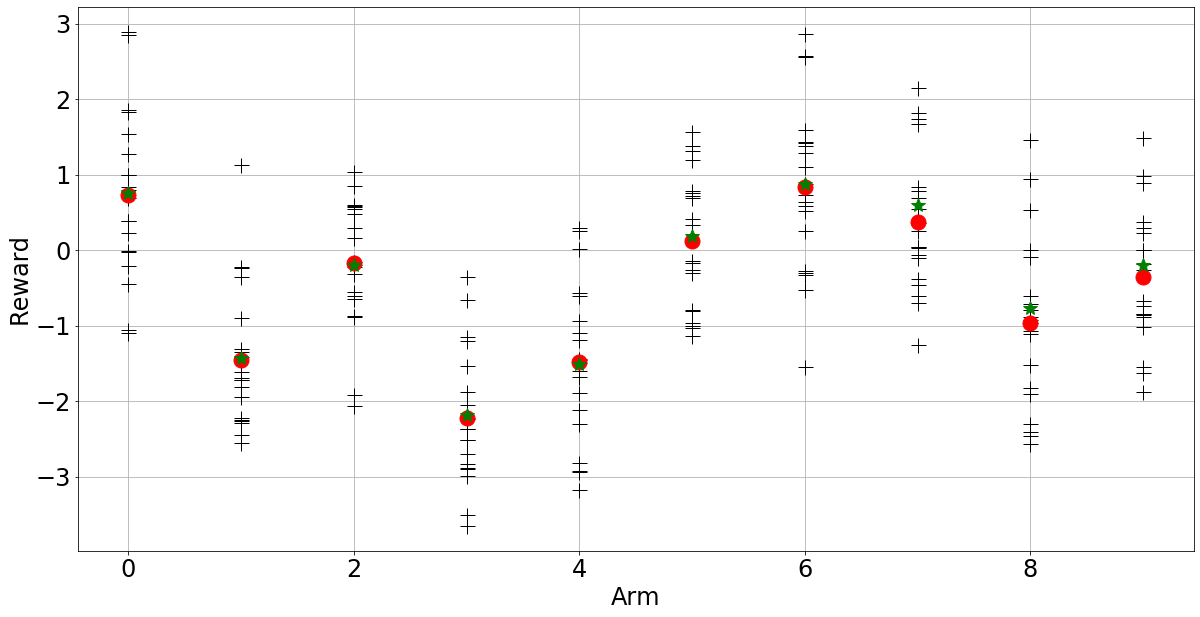

In [ ]:
# Autre modèle bandits: bras avec distribution gaussienne
gaussian_bandits_pb = NormalMultiArmedBandits(n_arms=10)
# Tirer 100 fois chaque bras et afficher les récompenses
# et comparer la moyenne des gains aux vraies valeurs des bras (espérances inconnues)
n_draws = 20
for i_arm in range(gaussian_bandits_pb.n_arms):
    x = 0
    for i_draw in range(n_draws):
        r = gaussian_bandits_pb.step(i_arm)
        x += r
        plt.plot(i_arm, r, '+k')
    plt.plot(i_arm, x/n_draws, 'or')
    plt.plot(i_arm, gaussian_bandits_pb._true_values[i_arm], '*g')
plt.grid()
plt.xlabel('Arm')
plt.ylabel('Reward')
print('Vraies valeurs des bras:', gaussian_bandits_pb._true_values)

**À retenir:**
- il y a plusieurs modèles de problèmes de bandits possibles (Bernoulli, gaussien, etc.)
- l'objet contient les vraies valeurs des bras, inconnues de l'agent (attribut `_true_values`)
- la méthode `step(a)` permet de jouer le bras `a` et renvoie la récompense obtenue

# Les algorithmes de bandits: la classe abstraite `BanditAlgorithm`
Dans `bandits.py`, on fournit une classe abstraite `BanditAlgorithm` générique pour les algorithmes de bandits:
* la méthode abstraite `get_action()` renvoie l'action choisie
* la méthode `fit_step(a, r)` prend en argument une action `a` et une récompense `r` obtenue suite à cette action pour apprendre à partir de cet exemple, par exemple en mettant à jour les estimations des valeurs des bras.  Plusieurs sous-classes sont proposées pour les différentes stratégies de résolution.


# On définit une fonction pour analyser les résultats des différentes stratégies

In [ ]:
def simulate_player_on_the_long_run(n_simulations, n_draws,
                                    bandit, strategy, **kwargs):
    # hold all performances of our simulation
    rewards_all = []
    regrets_all = []
    selected_arms_all = []

    # Gain moyen du bras optimal
    max_reward = np.max(bandit._true_values)

    for idx_simulation in range(n_simulations):
        if strategy == 'random':
            algorithm = RandomBanditAlgorithm(n_arms=bandit.n_arms)
        elif strategy == 'greedy':
            algorithm = GreedyBanditAlgorithm(n_arms=bandit.n_arms)
        elif strategy == 'epsilon-greedy':
            algorithm = EpsilonGreedyBanditAlgorithm(n_arms=bandit.n_arms,
                                                    epsilon=kwargs['epsilon'])
        elif strategy == 'UCB':
            algorithm = UcbBanditAlgorithm(n_arms=bandit.n_arms,
                                           c=kwargs['c'])
        elif strategy == 'TS':
            algorithm = ThompsonSamplingAlgorithm(n_arms=bandit.n_arms)
        else:
            raise ValueError(f"Strategy {strategy} isn't implemented yet.")

        # arrays to hold data for one simulation
        rewards_one = np.empty(n_draws)
        selected_arms_one = np.empty(n_draws)

        for idx_draw in range(n_draws):
            idx_arm = algorithm.get_action()  # Choix du bras par l'algo
            reward = bandit.step(idx_arm)  # Récompense obtenue
            algorithm.fit_step(action=idx_arm, reward=reward)  # mise à jour de l'algo
            
            # update our counters
            rewards_one[idx_draw] = reward
            selected_arms_one[idx_draw] = idx_arm
        
        # Calcul du regret
        cum_reward = np.cumsum(rewards_one)  # Récompenses cumulées
        regret = np.arange(1, n_draws+1) * max_reward - cum_reward

        rewards_all.append(cum_reward)
        regrets_all.append(regret)
        selected_arms_all.append(selected_arms_one)
    
    # transform to numpy array
    rewards_all = np.array(rewards_all)
    regrets_all = np.array(regrets_all)
    selected_arms_all = np.array(selected_arms_all)

    # summing the columns (calculate mean of all simulations)
    rewards_all = rewards_all.sum(axis=0) / n_simulations
    regrets_all = regrets_all.sum(axis=0) / n_simulations
    selected_arms_all = selected_arms_all.sum(axis=0) / n_simulations

    return {
        'rewards': rewards_all,
        'regrets': regrets_all,
        'selected_arms': selected_arms_all
    }

# On définit une fonction pour afficher les performances des différentes stratégies

In [ ]:
def display_reward_and_regret(bandit, strategies, n_draws):
    # On trace le gain moyen en fonction des itérations
    reward_max = np.max(bandit._true_values)
    plt.semilogx([0, n_draws-1], [reward_max, reward_max], '--g', label='best average')

    plt.xlabel('Iterations')
    plt.ylabel('Average gain')
    for name, strategy in strategies.items():
        plt.semilogx(strategy['rewards'] / np.arange(1, n_draws+1), label=name)
    plt.grid()
    plt.legend()
    plt.show()

    plt.xlabel('Iterations')
    plt.ylabel('Selected arms')
    # On trace les bras sélectionnés en fonction des itérations
    for name, strategy in strategies.items():
        plt.semilogx(strategy['selected_arms'], label=name)
    plt.grid()
    plt.legend()
    plt.show()

    plt.xlabel('Iterations')
    plt.ylabel('Regret')
    # On trace le regret en fonction des itérations
    for name, strategy in strategies.items():
        plt.semilogx(strategy['regrets'], label=name)
    plt.grid()
    plt.legend()
    plt.show()

# On définit une fonction pour filtrer les résultats à afficher

In [ ]:
def filter_results(results, search_keys):
    filtered_results = dict()
    for key, value in results.items():
        for search_key in search_keys:
            if search_key in key:
                filtered_results[key] = value
    return filtered_results

# Initialisation des variables communes

In [ ]:
N_DRAWS = 10 ** 4
N_SIMULATIONS = 50
BANDIT = BernoulliMultiArmedBandits(true_values=[0.1, 0.85, 0.7, 0.8])
RESULTS = dict()

# Stratégie aléatoire

On utilise ici la classe `RandomBanditAlgorithm` qui implémente un algorithme de bandit qui choisit une action totalement aléatoirement, sans rien apprendre.

**À faire.** Étudiez le code de cette classe (constructeur, méthodes à `get_action` et `fit_step`).

**À faire sur papier.** Calculez le gain moyen de ce joueur en fonction des vraies valeurs des bras.

**Réponse.** gain_random : $\frac{1}{n}\sum_i X_i \forall i \in [1, n]$ avec $X_i$ le gain moyen du bras $i$. 

Le code ci-dessous est une simulation classique de l'interaction entre un algorithme de bandit et son environnement: choix du bras, récompense, entrainement online.

In [ ]:
# Création de l'algo
rand_algo = RandomBanditAlgorithm(n_arms=bandits_pb.n_arms)
# On choisit un bras et on observe la récompense, le tout 15 fois
for i in range(15):
    i_arm = rand_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    rand_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    print('Bras {} -> récompense {}'.format(i_arm, r))

Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 3 -> récompense False
Bras 2 -> récompense False
Bras 0 -> récompense False
Bras 2 -> récompense True
Bras 3 -> récompense True
Bras 1 -> récompense True
Bras 3 -> récompense True
Bras 0 -> récompense False
Bras 3 -> récompense True
Bras 1 -> récompense True
Bras 2 -> récompense False
Bras 3 -> récompense False
Bras 0 -> récompense False


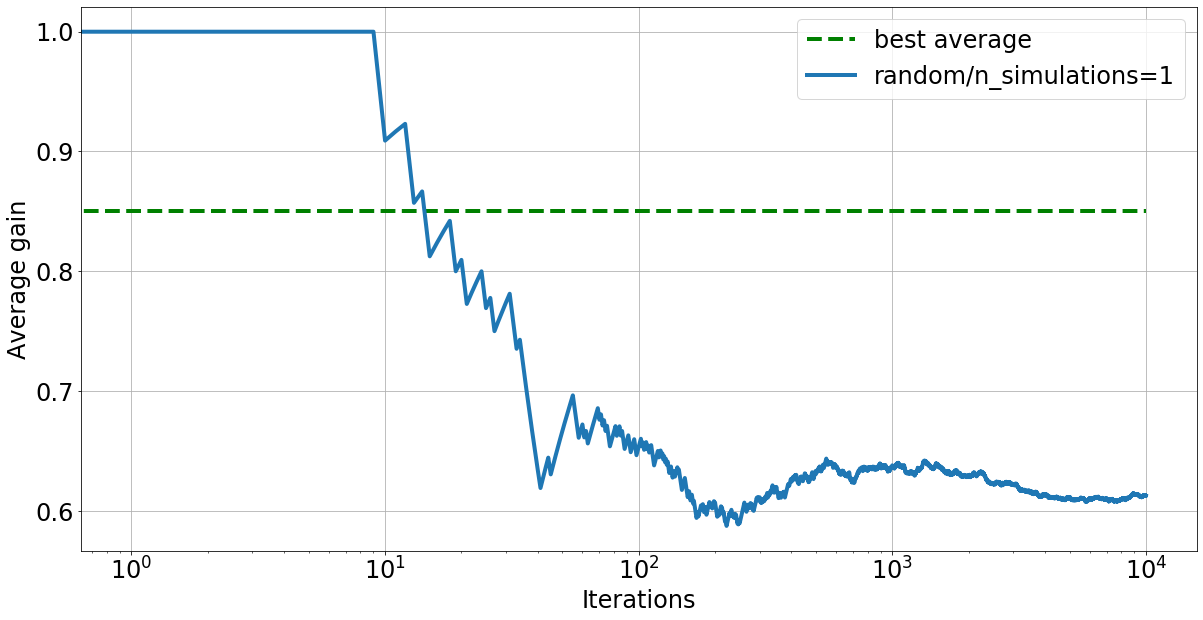

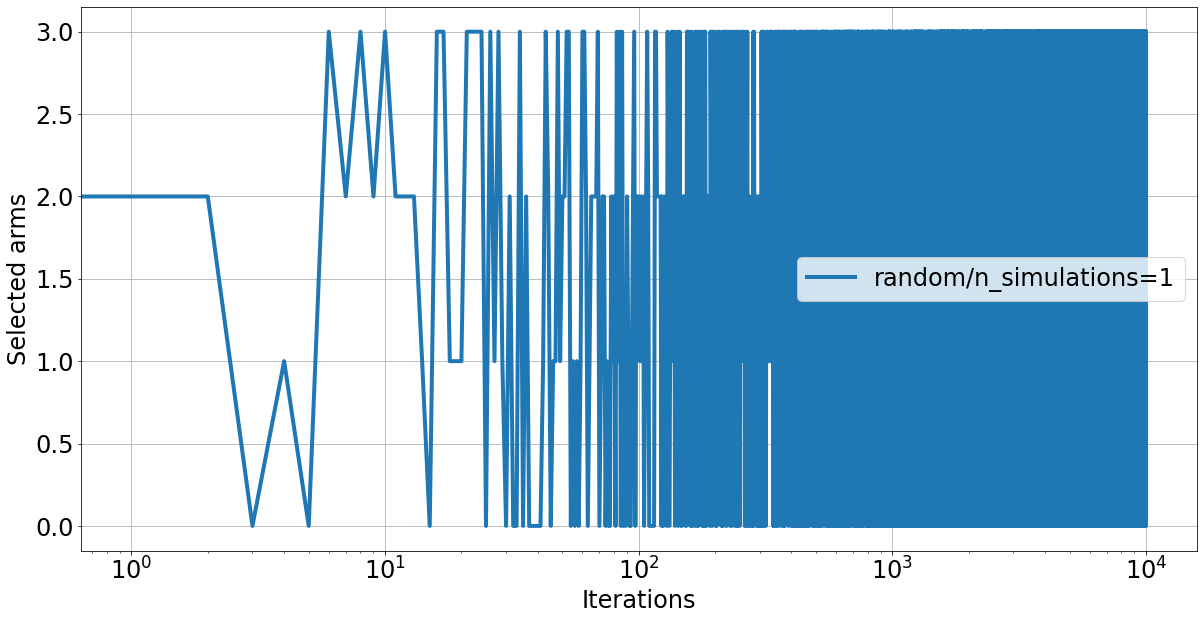

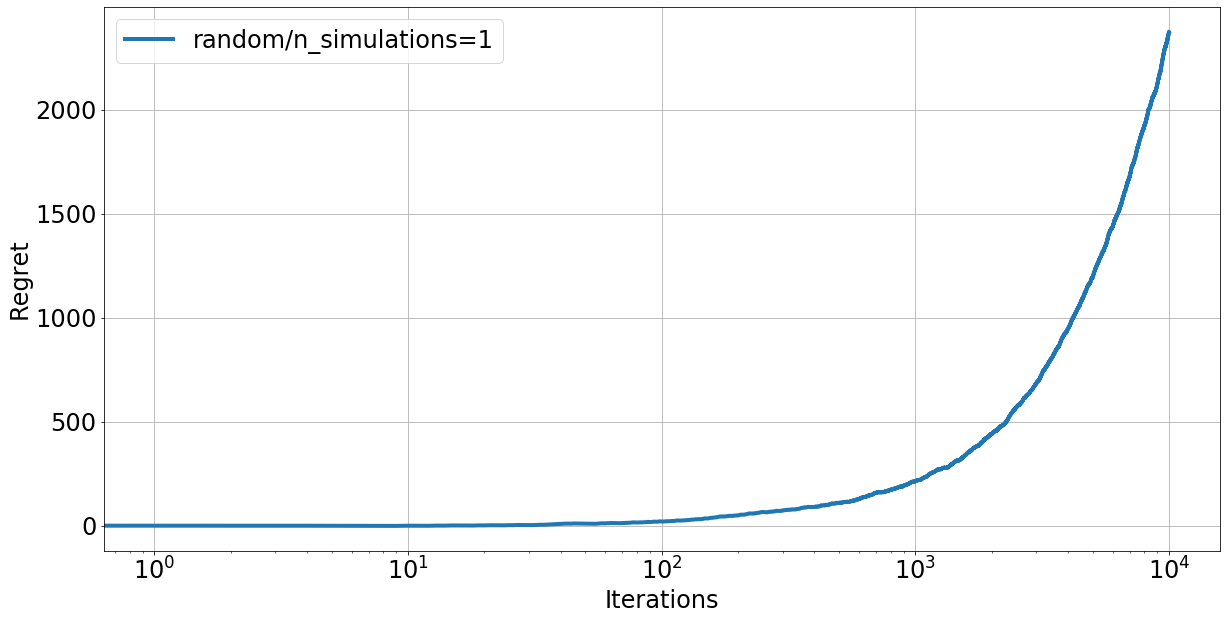

In [ ]:
RESULTS[f'random/n_simulations={1}'] = simulate_player_on_the_long_run(
    n_simulations=1,
    n_draws=N_DRAWS,
    bandit=BANDIT,
    strategy='random'
)

to_plot = filter_results(RESULTS, ['random'])

display_reward_and_regret(BANDIT, to_plot, N_DRAWS)

# Stratégie greedy

**Question à chercher sur papier.** On cherche à mettre à jour les moyennes des gains de chaque bras de façon online. Pour tout $n>0$, on note $\mu_n=\frac{1}{n}\sum_{i=1}^{n} x_i$ la moyenne de $n$ valeurs $x_i$, avec $\mu_0=0$. Montrer mathématiquement que pour tout $n>1$, on a $\mu_n = \mu_{n-1} + \frac{1}{n} \left (x_n - \mu_{n-1}\right )$.

**Réponse, raisonnement par récurrence**

* on veut montrer que la propriété est vrai pour $n = 1$
    * $\mu_1 = \mu_0 + \frac{1}{1}(x_1 - \mu_0)$
    * $\mu_1 = x_1$
    * la moyenne d'un seul tirage est l'unique tirage, logique : propriété prouvée au rang 1.

* on veut maintenant montrer que $\mu_{n+1} = \mu_n + \frac{1}{n+1} (x_{n+1} - \mu_n)$
    * $\mu_{n+1} = \mu_{n-1} + \frac{1}{n} (x_n - \mu_{n-1}) + \frac{1}{n+1} (x_{n+1} - \mu_n)$
    * on remarque que la première partie est en fait $\mu_n$, donc on réécrit :
        * $\mu_{n+1} = \mu_n + \frac{1}{n+1}(x_{n+1} - \mu_n)$
    * par récurrence, on conclut que si la propriété est vraie au rang initial et à un rang $n+1$, elle l'est par hérédité au rang $n$.

**À faire.** En utilisant la formule précédentes, complétez la méthode `fit_step` de la classe `GreedyBanditAlgorithm` puis implémentez sa méthode `get_action`.

In [ ]:
# Création de l'algo
greedy_algo = GreedyBanditAlgorithm(n_arms=bandits_pb.n_arms)
# On choisit un bras et on observe la récompense, le tout 15 fois
for i in range(15):
    i_arm = greedy_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    greedy_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    print('Bras {} -> récompense {}'.format(i_arm, r))

Bras 0 -> récompense True
Bras 1 -> récompense True
Bras 2 -> récompense False
Bras 3 -> récompense True
Bras 0 -> récompense False
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense False
Bras 3 -> récompense False
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True


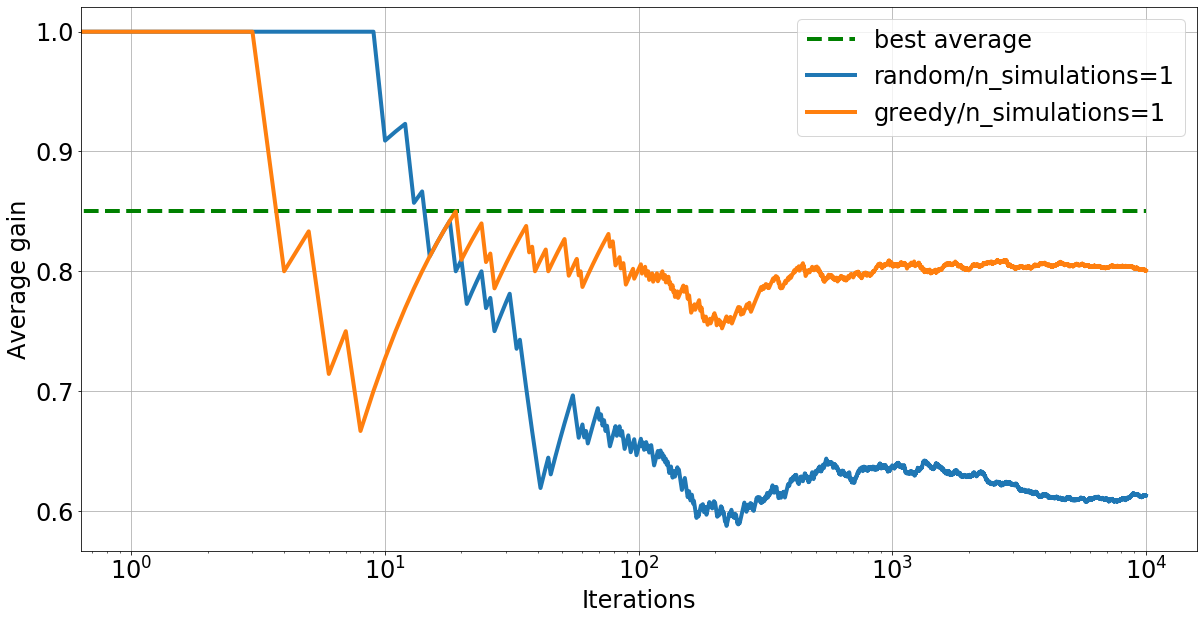

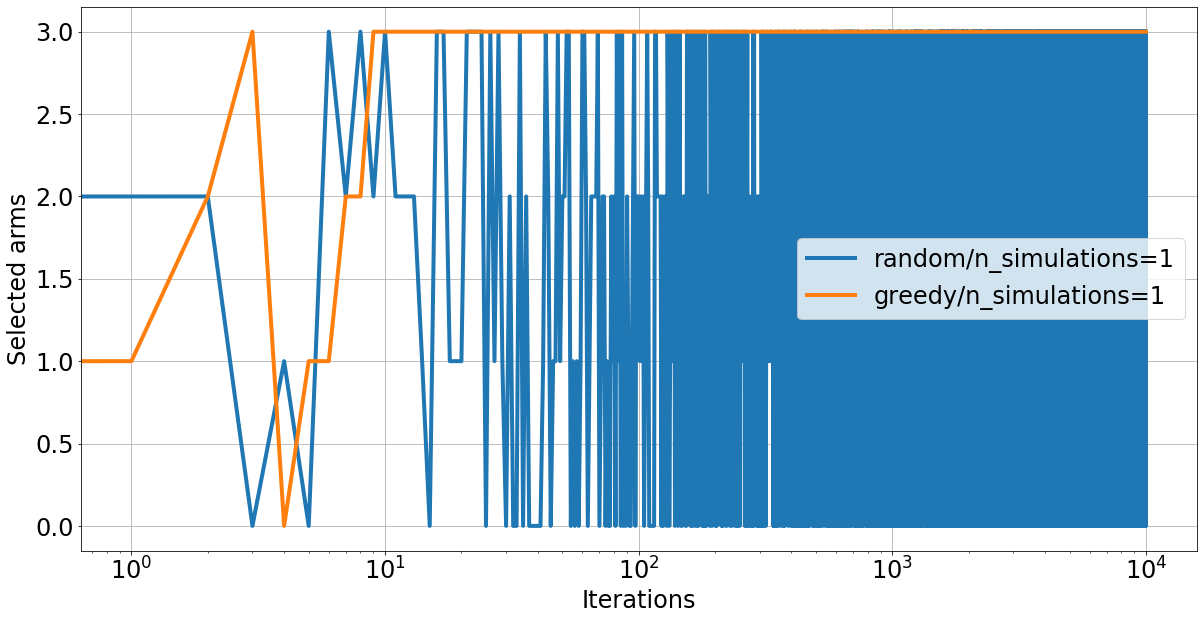

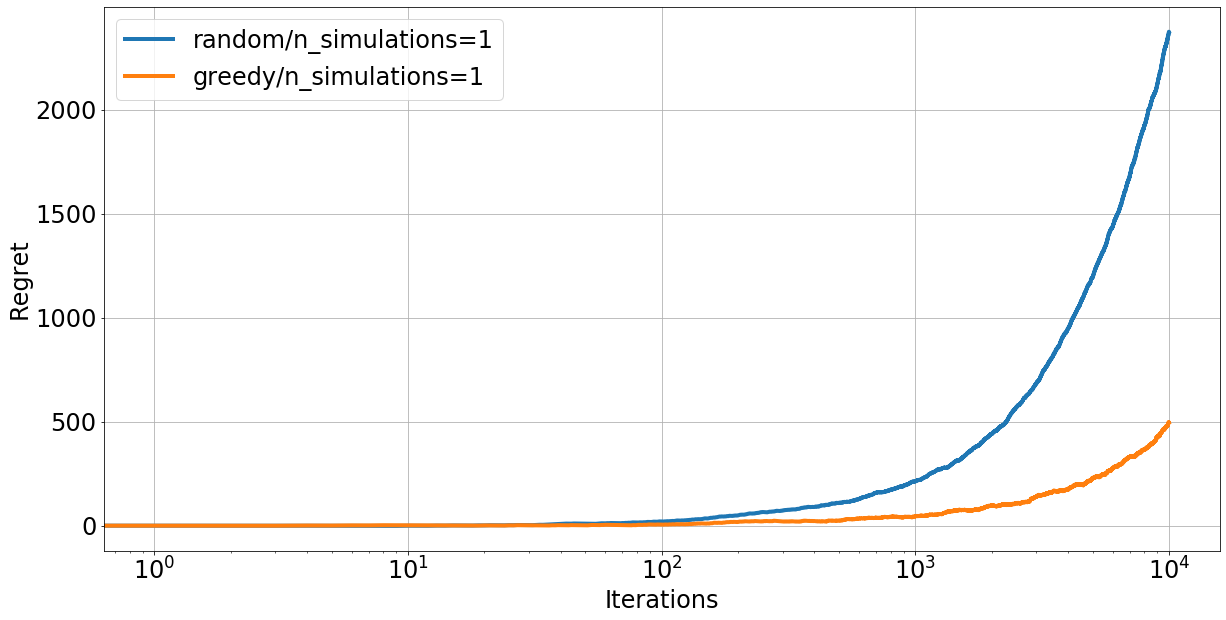

In [ ]:
RESULTS[f'greedy/n_simulations={1}'] = simulate_player_on_the_long_run(
    n_simulations=1,
    n_draws=N_DRAWS,
    bandit=BANDIT,
    strategy='greedy'
)

to_plot = filter_results(RESULTS, ['random', 'greedy'])
display_reward_and_regret(BANDIT, to_plot, N_DRAWS)

**À faire.** La stratégie greedy peut rester piégée dans un mauvais choix. Répétez l'expérience précédente un grand nombre de fois (50) en réinitialisant l'algorithme à chaque fois; calculer ensuite un regret moyen par rapport à toutes les initialisations de l'algorithme et tracez-le.

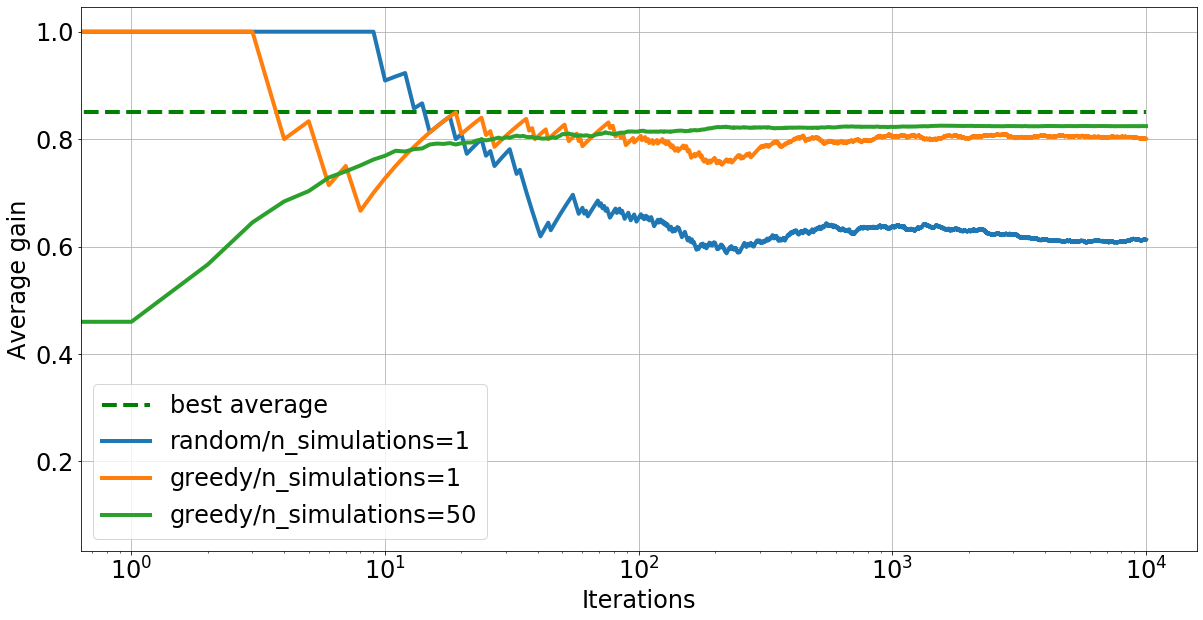

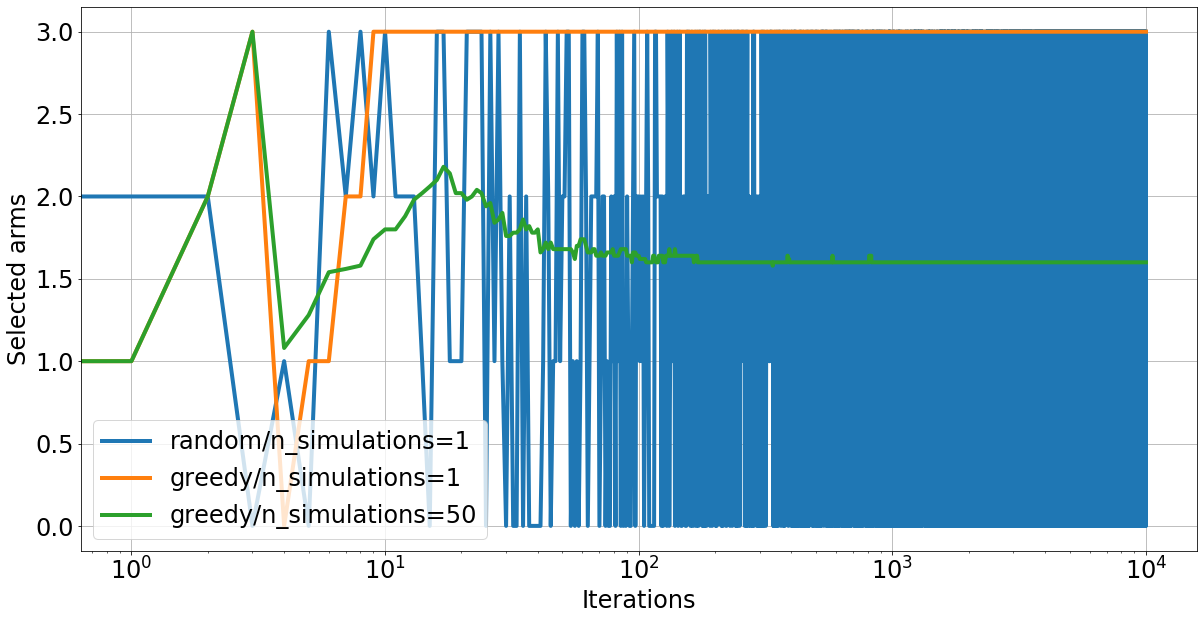

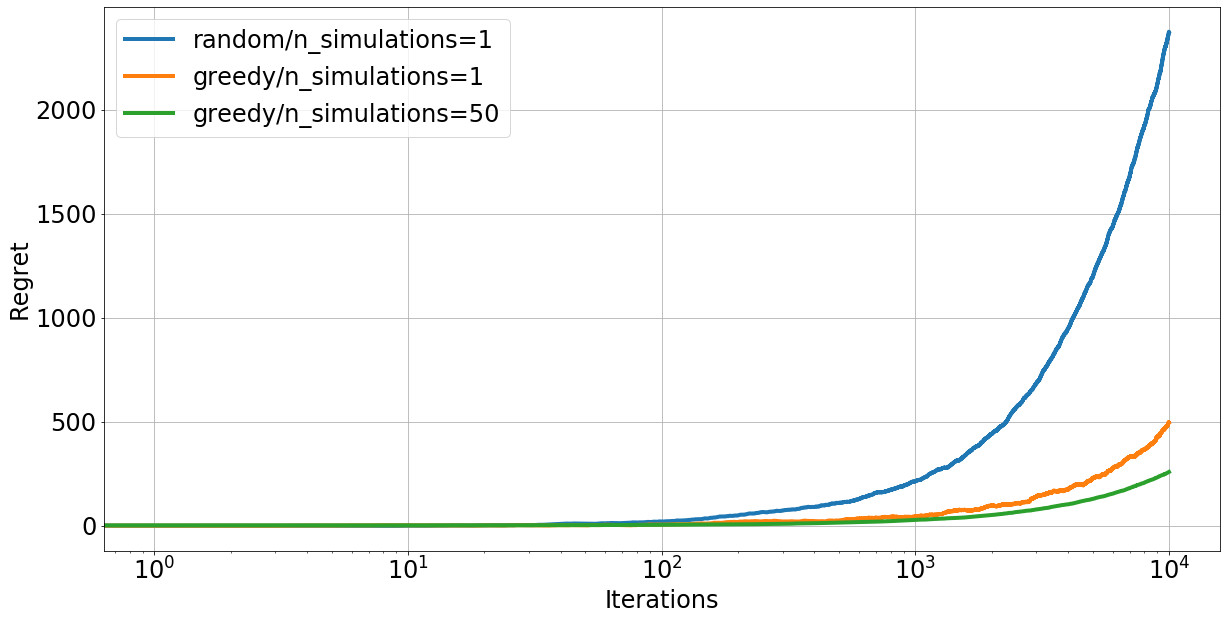

In [ ]:
RESULTS[f'greedy/n_simulations={N_SIMULATIONS}'] = simulate_player_on_the_long_run(
    n_simulations=N_SIMULATIONS,
    n_draws=N_DRAWS,
    bandit=BANDIT,
    strategy='greedy'
)

to_plot = filter_results(RESULTS, ['random', 'greedy'])
display_reward_and_regret(BANDIT, to_plot, N_DRAWS)

In [ ]:
# Correction
try:
    my_vars = dict()
    my_vars['bandits_pb'] = bandits_pb
    my_vars['n_draws'] = n_draws
    my_vars['regret_rand'] = regret_rand
    my_vars['cum_reward_rand'] = cum_reward_rand
    exp_correction.exp_greedy(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

Ignorer cette cellule, elle ne sert qu'à l'enseignant!


 # Stratégie $\epsilon$-greedy
**À faire.** Complétez les méthodes `fit_step` et `get_action` de la classe `EpsilonGreedyBanditAlgorithm`, réalisez l'expérience précédente dans le cas de la stratégie $\epsilon$-greedy et tracez les résultats de toutes les stratégies en les superposant. Vous pourrez fixer $\epsilon=0.01$ dans un premier temps. Tester ensuite plusieurs valeurs de $\epsilon$ telles que $\epsilon=0.1$ et $\epsilon=0$, superposez les courbes et commentez-les.

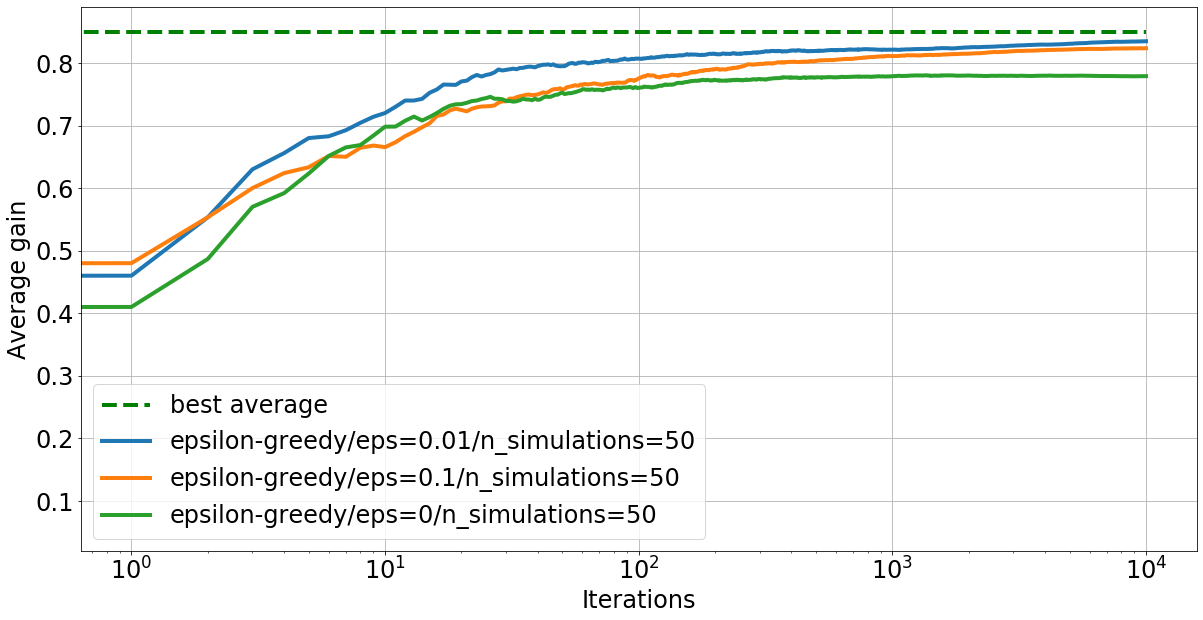

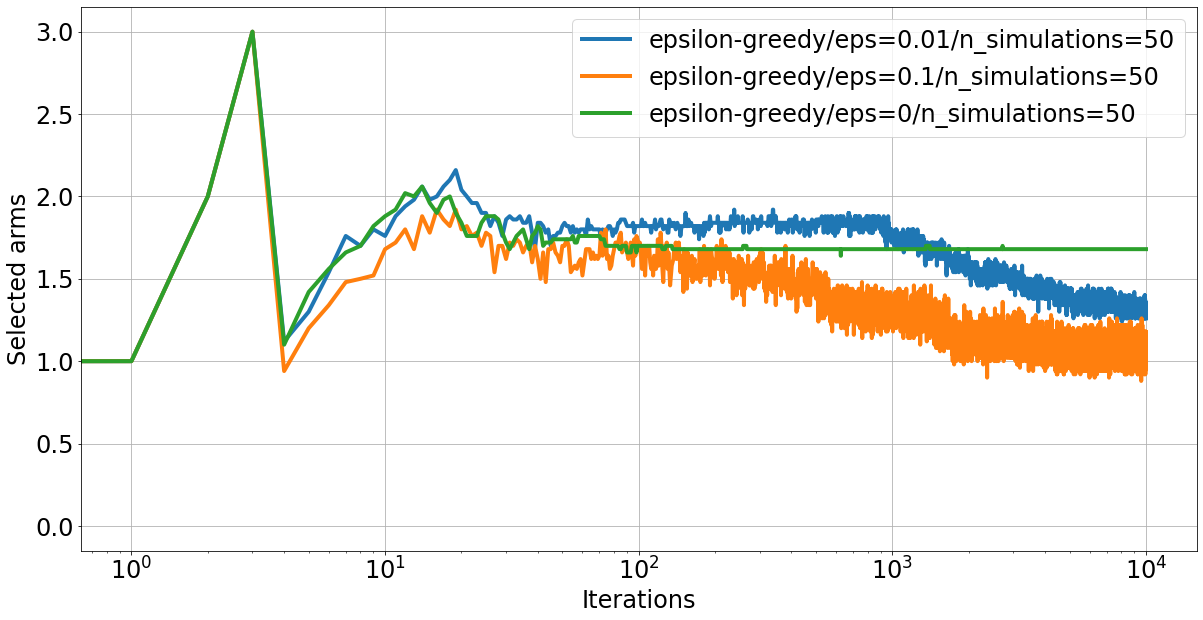

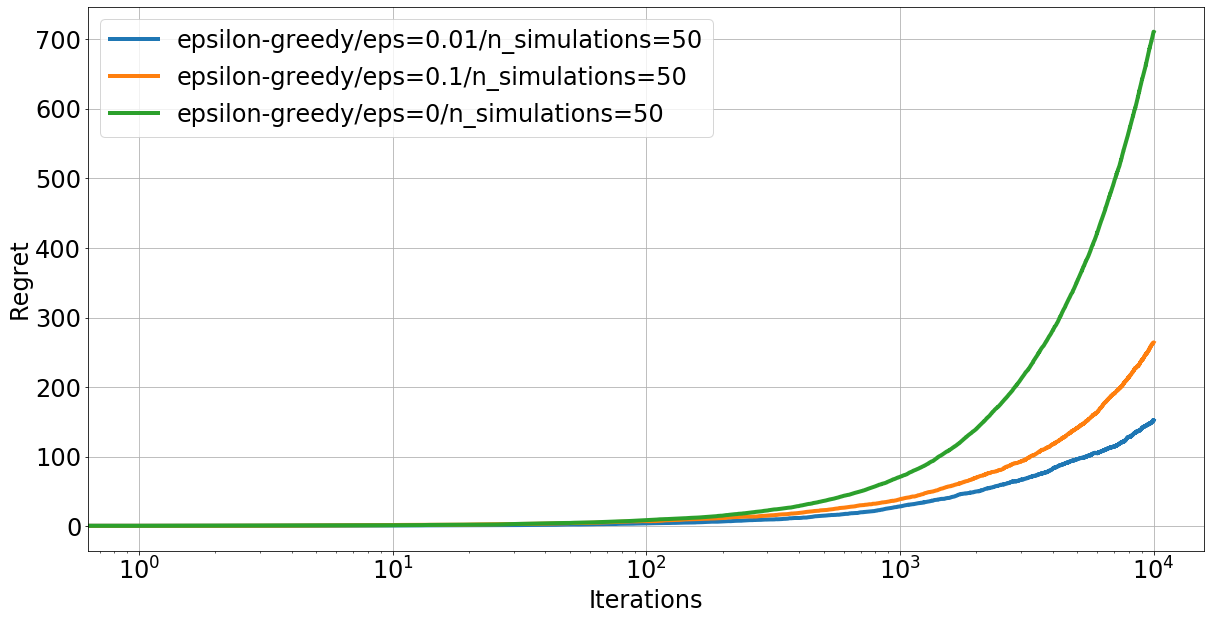

In [ ]:
epsilons = [0.01, 0.1, 0]

for epsilon in epsilons:
    RESULTS[f'epsilon-greedy/eps={epsilon}/n_simulations={N_SIMULATIONS}'] = simulate_player_on_the_long_run(
        n_simulations=N_SIMULATIONS,
        n_draws=N_DRAWS,
        bandit=BANDIT,
        strategy='epsilon-greedy',
        epsilon=epsilon
    )

to_plot = filter_results(RESULTS, ['epsilon-greedy'])
display_reward_and_regret(BANDIT, to_plot, N_DRAWS)

In [ ]:
# Correction
try:
    from exp_correction import exp_epsgreedy_1
    exp_epsgreedy_1(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

Ignorer cette cellule, elle ne sert qu'à l'enseignant!


In [ ]:
# Correction
try:
    exp_correction.exp_epsgreedy_50(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

Ignorer cette cellule, elle ne sert qu'à l'enseignant!


 # Stratégie UCB

**À faire.** Complétez les méthodes `fit_step` et `get_action` de la classe `UcbBanditAlgorithm`, réalisez l'expérience précédente dans le cas de la stratégie UCB et tracez les résultats de toutes les stratégies en les superposant.

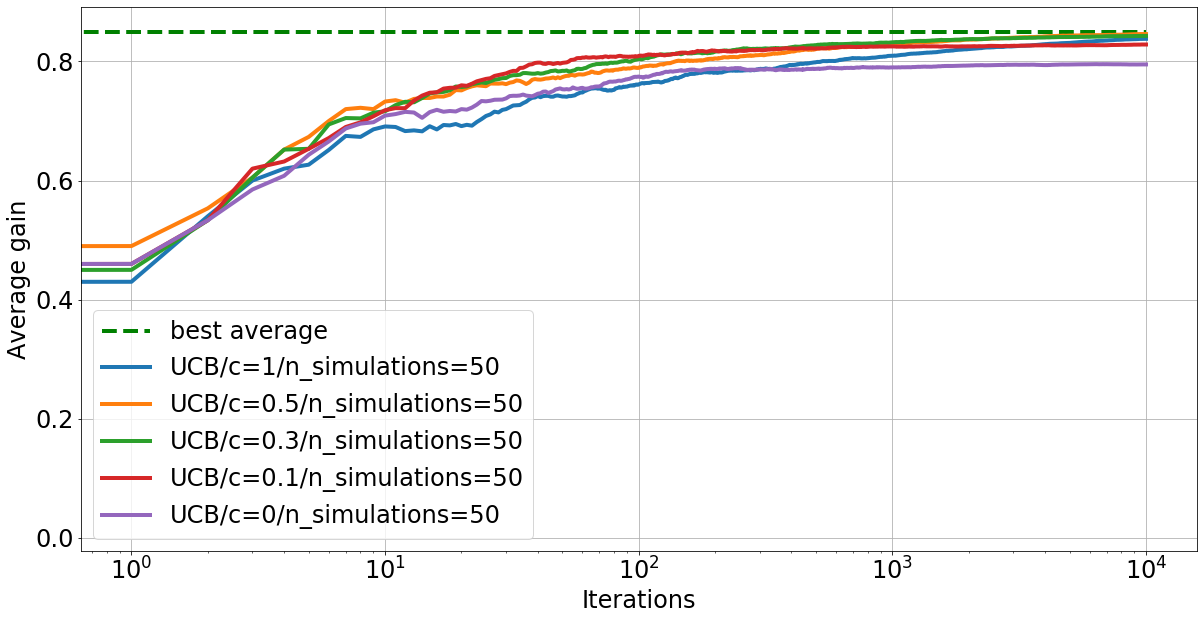

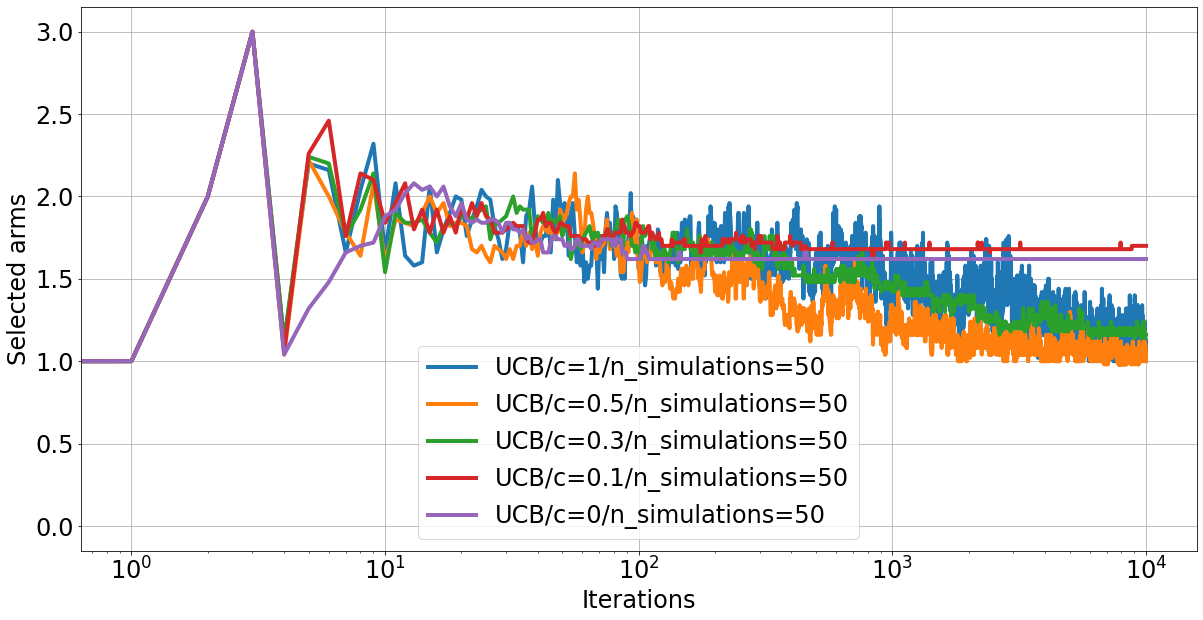

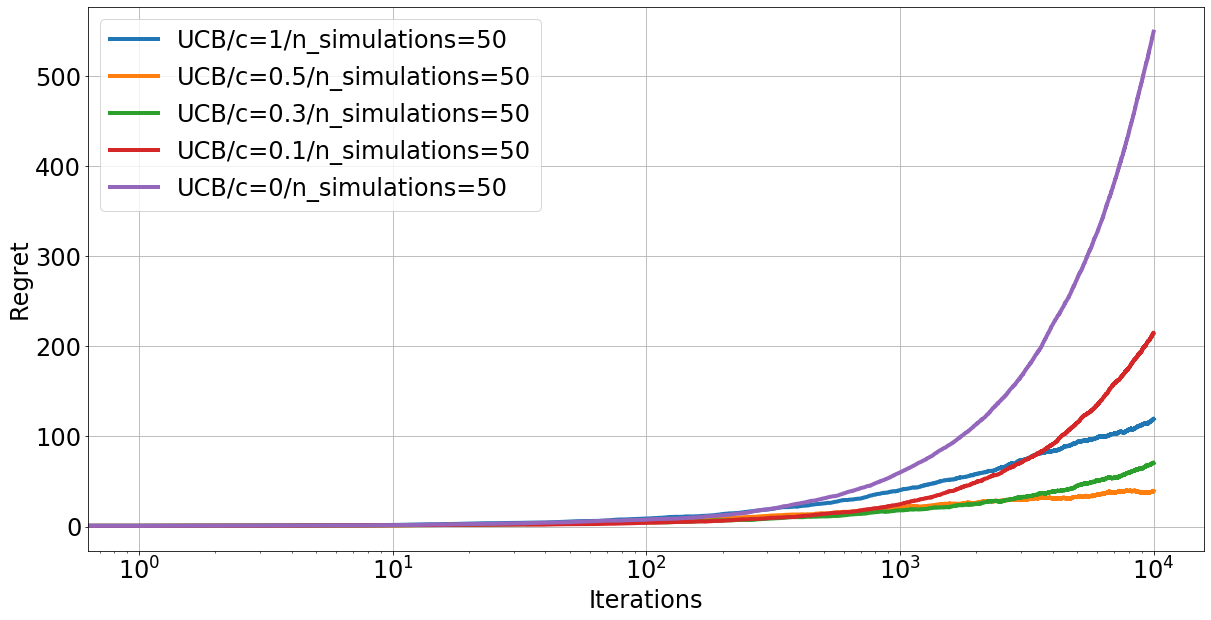

In [ ]:
C = [1, 0.5, 0.3, 0.1, 0]

for c in C:
    RESULTS[f'UCB/c={c}/n_simulations={N_SIMULATIONS}'] = simulate_player_on_the_long_run(
        n_simulations=N_SIMULATIONS,
        n_draws=N_DRAWS,
        bandit=BANDIT,
        strategy='UCB',
        c=c
    )

to_plot = filter_results(RESULTS, ['UCB'])
display_reward_and_regret(BANDIT, to_plot, N_DRAWS)

In [ ]:
# Correction
try:
    exp_correction.exp_ucb(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

Ignorer cette cellule, elle ne sert qu'à l'enseignant!


**À faire.** Pour UCB, tracez, en fonction des itérations, la moyenne et la borne supérieure de chaque bras en superposant les courbes sur un unique graphique (dans le même esprit que dans le cours). Analysez la figure obtenue.

In [ ]:
def get_bounds_means_ucb(n_simulations, n_draws,
                          bandit, c):
    algo = UcbBanditAlgorithm(n_arms=bandit.n_arms, c=c)

    # arrays to hold data for one simulation
    max_reward = np.max(bandit._true_values)
    rewards = np.empty(n_draws)

    # pour plot les intervales + moyennes des bras
    bounds = np.empty((bandit.n_arms, n_draws))
    means = np.empty((bandit.n_arms, n_draws))

    for idx_draw in range(n_draws):
        chosen_idx_arm = algo.get_action()  # Choix du bras par l'algo
        reward = bandit.step(chosen_idx_arm)  # Récompense obtenue
        algo.fit_step(action=chosen_idx_arm, reward=reward)  # mise à jour de l'algo
        
        # update our counters
        rewards[idx_draw] = reward
        for idx_arm in range(bandit.n_arms):
            bounds[idx_arm][idx_draw] = algo._upper_confidence_bounds[idx_arm]
            means[idx_arm][idx_draw] = algo._value_estimates[idx_arm]
        
    rewards = np.cumsum(rewards)
    
    # on commence à afficher les intervales quand tous les bras ont été
    # visités sinon ils explosent
    idx_start = bandit.n_arms

    return rewards[idx_start:], means[:, idx_start:], bounds[:, idx_start:]

In [ ]:
def plot_bounds_means_ucb(rewards, means, bounds, bandit, n_draws):
    # moyenne et bornes des bras
    # 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'
    colors = ['c', 'g', 'r', 'b']
    idx_arm = 0

    for mean, bound, color in zip(means, bounds, colors):
        upper_bound = mean + bound
        lower_bound = mean - bound
        # intervales de confiance
        plt.fill_between(range(mean.shape[0]),
                        upper_bound, lower_bound,
                        color=color, alpha=0.3)
        
        # estimation du bras
        plt.semilogx(mean, color, label=f'arm-{idx_arm}')

        # vraie valeur du bras en pointillés
        plt.semilogx([0, mean.shape[0]-1], [bandit._true_values[idx_arm], bandit._true_values[idx_arm]], f'{color}--')
        idx_arm += 1

    # affichage du gain moyen par UCB
    plt.semilogx(rewards / np.arange(1, n_draws - bandit.n_arms + 1),
                color='black', label=f'UCB/c={best_c}')

    plt.grid()
    plt.legend()
    plt.show()

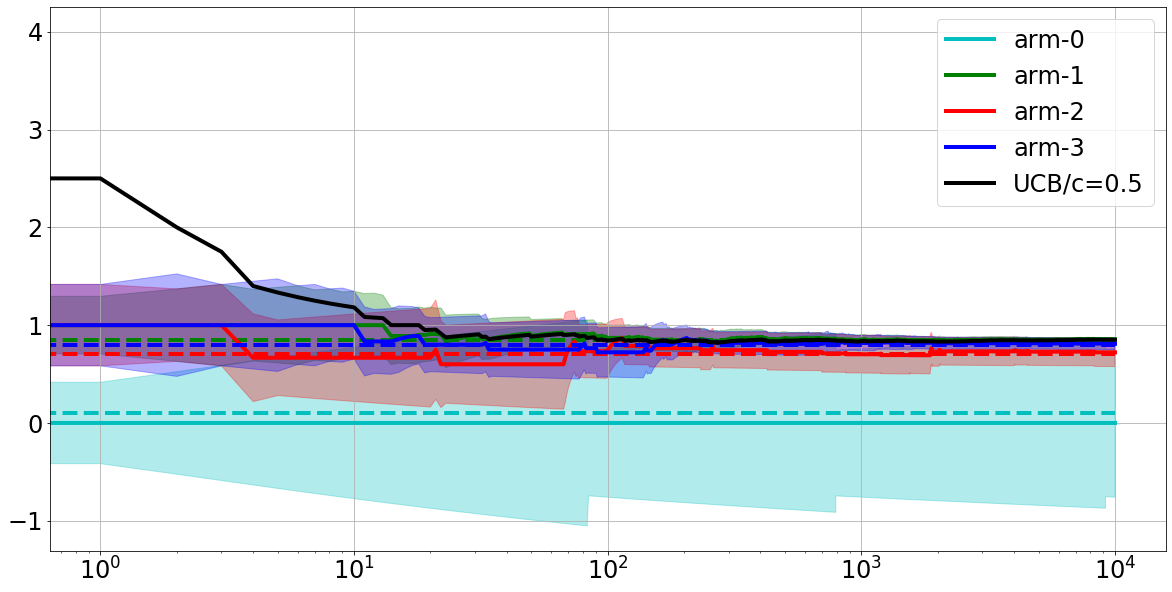

In [ ]:
best_c = 0.5
rewards, means, bounds = get_bounds_means_ucb(1, N_DRAWS,
                                              BANDIT, c=best_c)
plot_bounds_means_ucb(rewards, means, bounds, BANDIT, N_DRAWS)

In [ ]:
# Correction
try:
    exp_correction.exp_ucb_tracking(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

Ignorer cette cellule, elle ne sert qu'à l'enseignant!


 # Stratégie Thomson Sampling
 **À faire (séance 2).** Complétez les méthodes `fit_step` et `get_action` de la classe `ThompsonSamplingAlgorithm`, réalisez l'expérience précédente dans le cas de la stratégie UCB et tracez les résultats de toutes les stratégies en les superposant.

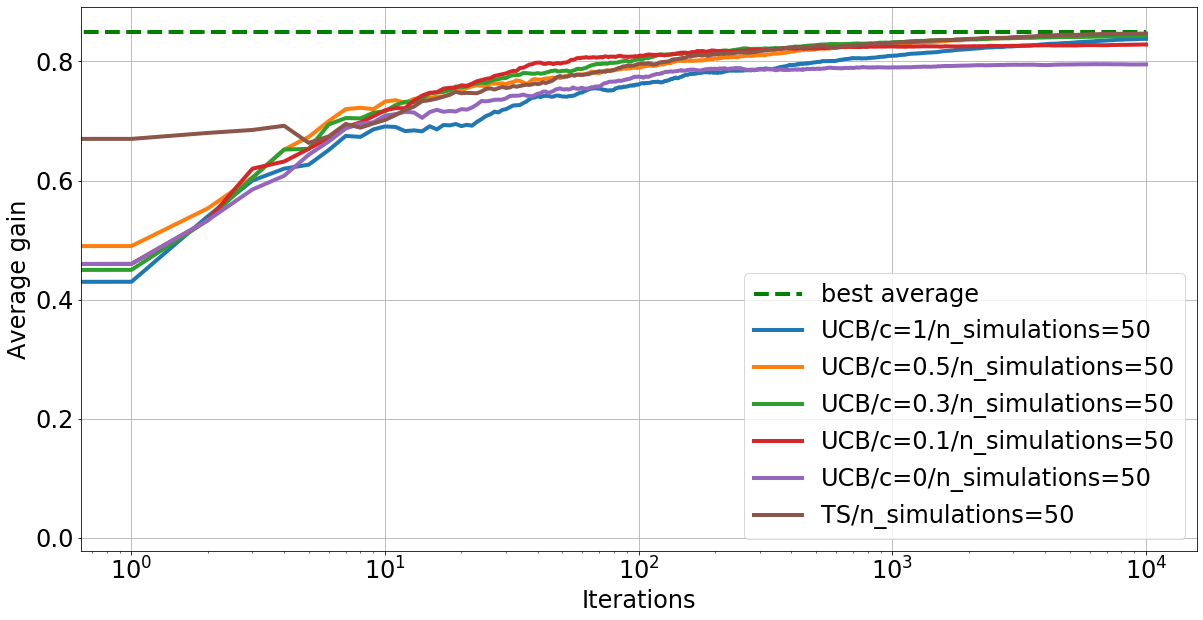

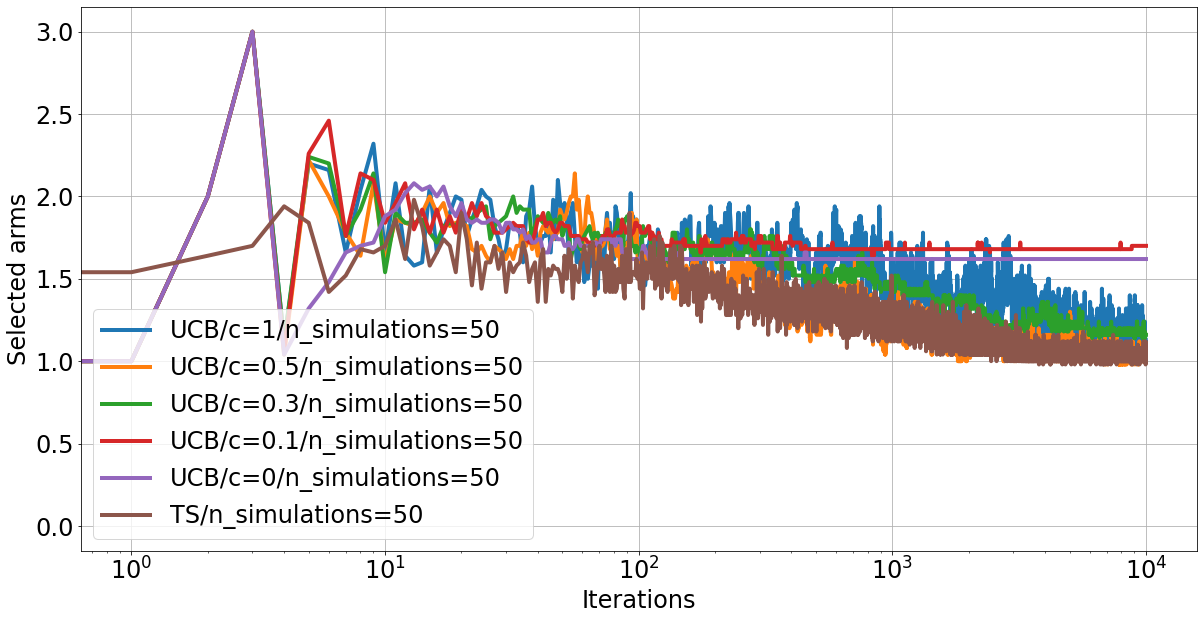

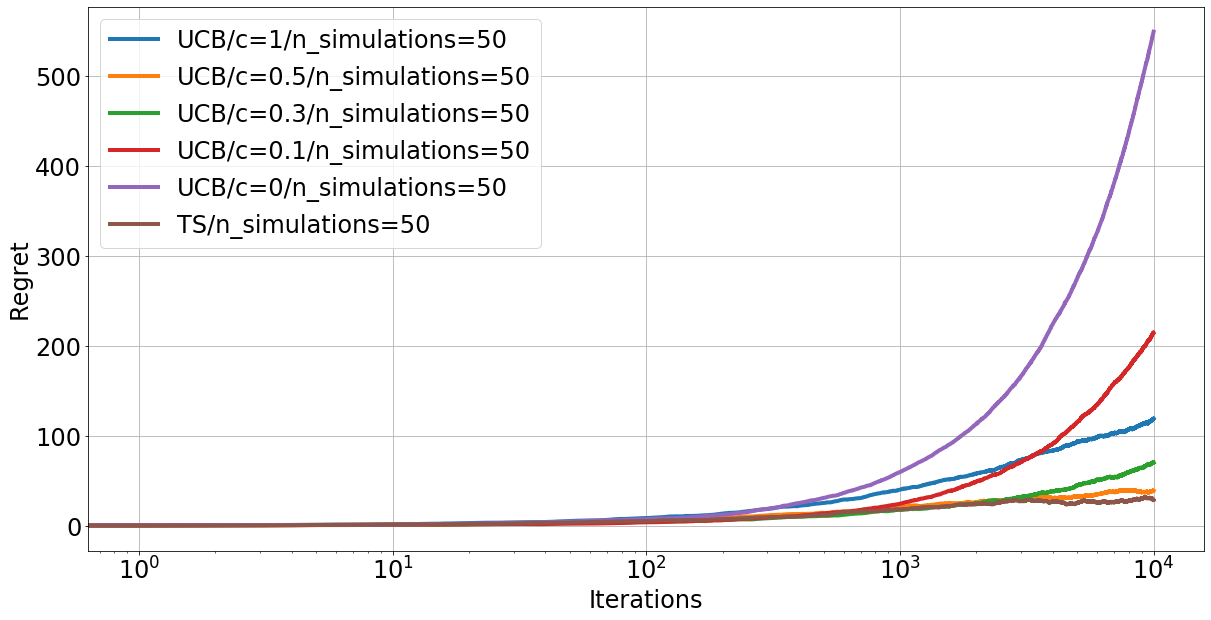

In [ ]:
RESULTS[f'TS/n_simulations={N_SIMULATIONS}'] = simulate_player_on_the_long_run(
    n_simulations=N_SIMULATIONS,
    n_draws=N_DRAWS,
    bandit=BANDIT,
    strategy='TS'
)

to_plot = filter_results(RESULTS, ['TS', 'UCB'])
display_reward_and_regret(BANDIT, to_plot, N_DRAWS)

## Analyse des alphas et betas pour chaque bras

In [ ]:
def plot_TS(rewards, alphas, betas):
    # 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'
    colors = ['c', 'g', 'r', 'b']
    idx_arm = 0

    plt.xscale('log')
    plt.yscale('log')

    for alpha, beta, color in zip(alphas, betas, colors):
        # estimation du bras
        plt.plot(alpha, color, label=f'arm-{idx_arm}')
        plt.plot(beta, f'{color}--')
        idx_arm += 1

    plt.grid()
    plt.legend()
    plt.show()

def run_analysis_TS(n_simulations, n_draws, bandit):
    algo = ThompsonSamplingAlgorithm(n_arms=bandit.n_arms)

    # arrays to hold data for one simulation
    max_reward = np.max(bandit._true_values)
    rewards = np.empty(n_draws)

    # pour plot les intervales + moyennes des bras
    alphas = np.empty((bandit.n_arms, n_draws))
    betas = np.empty((bandit.n_arms, n_draws))

    for idx_draw in range(n_draws):
        chosen_idx_arm = algo.get_action()  # Choix du bras par l'algo
        reward = bandit.step(chosen_idx_arm)  # Récompense obtenue
        algo.fit_step(action=chosen_idx_arm, reward=reward)  # mise à jour de l'algo
        
        # update our counters
        rewards[idx_draw] = reward
        for idx_arm in range(bandit.n_arms):
            alphas[idx_arm][idx_draw] = algo._alphas[idx_arm]
            betas[idx_arm][idx_draw] = algo._betas[idx_arm]
        
    rewards = np.cumsum(rewards)

    # plot
    plot_TS(rewards, alphas, betas)

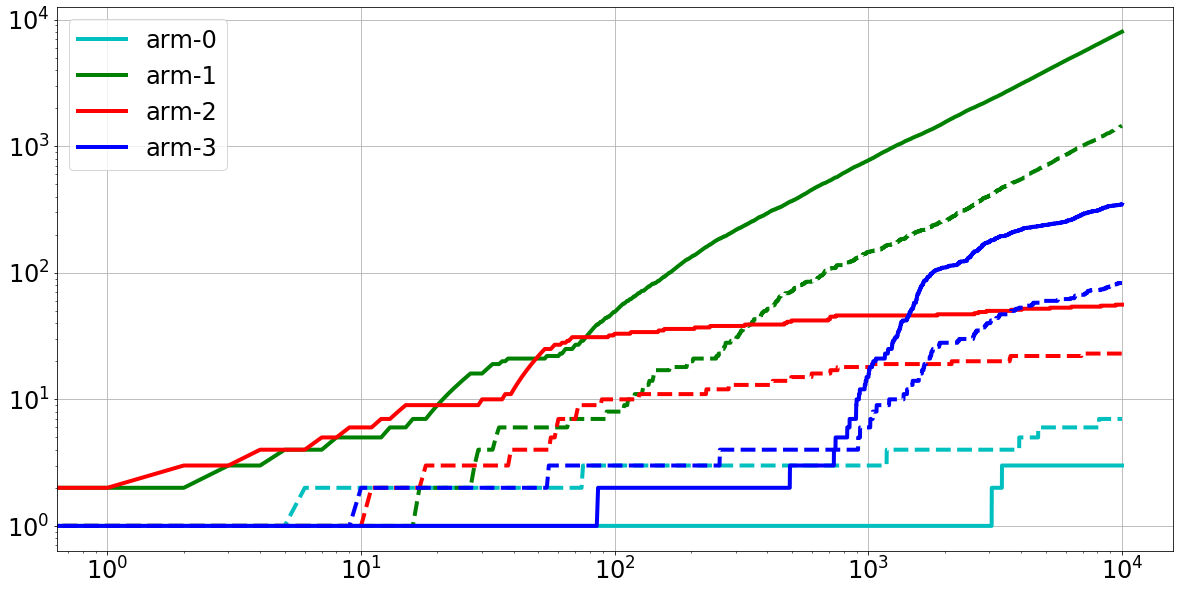

In [ ]:
run_analysis_TS(1, N_DRAWS, BANDIT)

In [ ]:
# Correction
try:
    exp_correction.exp_ts(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

Ignorer cette cellule, elle ne sert qu'à l'enseignant!
